# Predicting Taxi Fares

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import xgboost as xgb

import pickle

In [2]:
df = pd.read_csv('./data/train.csv' ,  parse_dates = ['pickup_datetime'], nrows = 2500000) # loading in just a fraction of the entire dataset
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### Data preprocessing and feature engineering

In [3]:
df = utils.feature_engineer(utils.preprocess(df))

Dataset after preprocessing

In [4]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,hour,travel_distance,pickup_dist_JFK_Airport,dropoff_dist_JFK_Airport,pickup_dist_Laguardia_Airport,dropoff_dist_Laguardia_Airport,pickup_dist_Newark_Airport,dropoff_dist_Newark_Airport
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,17,0.009436,0.101340,0.092710,0.055043,0.064326,0.337147,0.339123
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1,16,0.079696,0.245731,0.242961,0.157402,0.109925,0.165330,0.220812
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,0,0.013674,0.234714,0.237050,0.113076,0.122790,0.209742,0.198236
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,5,4,0.025340,0.225895,0.240846,0.122792,0.122149,0.197636,0.200358
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1,7,0.019470,0.225847,0.225878,0.098115,0.087741,0.225807,0.242228


### EDA 

In [5]:
landmarks = {'JFK Airport': (-73.78,40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}  

In [6]:
def plot_lat_long(df, landmarks, points = 'Pickup'):
    plt.figure(figsize = (12 , 12))
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude), '.', markersize = 1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude), '.', markersize = 1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1], 'o', markersize = 15, alpha = 1, color = 'r')
        plt.annotate(landmark, (landmarks[landmark][0] + 0.005, landmarks[landmark][1] + 0.005), color = 'r', backgroundcolor = 'w')
  
    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

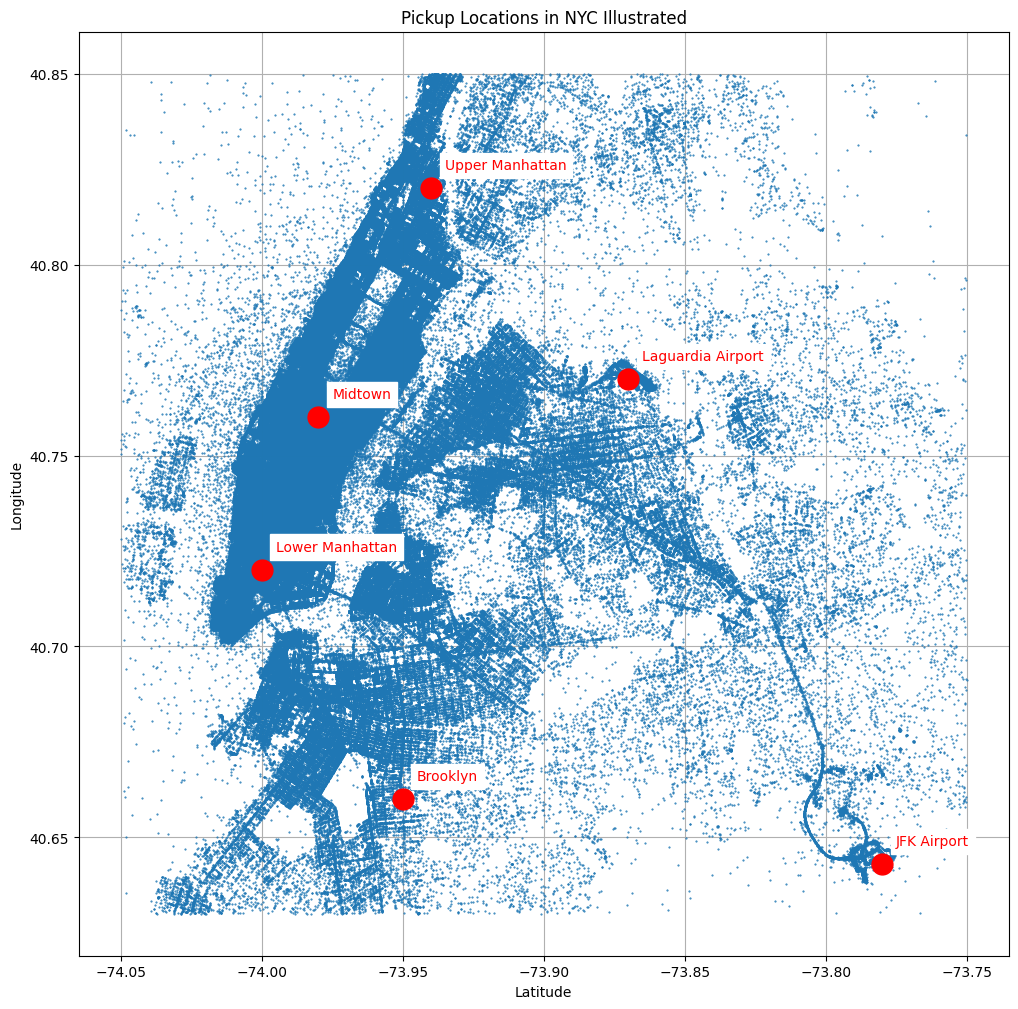

In [7]:
plot_lat_long(df, landmarks, points = 'Pickup')

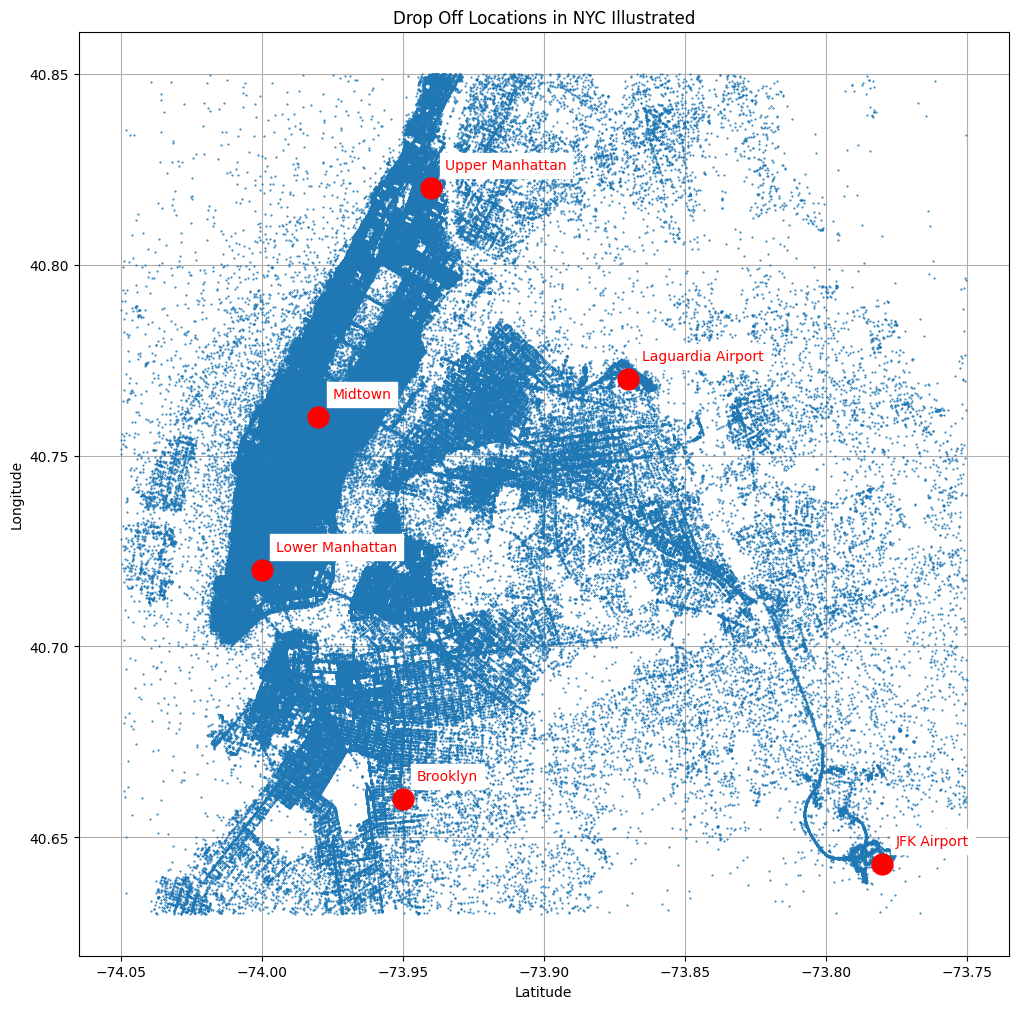

In [8]:
plot_lat_long(df , landmarks, points = 'Drop Off')

Text(0.5, 1.0, 'Day of Week Histogram')

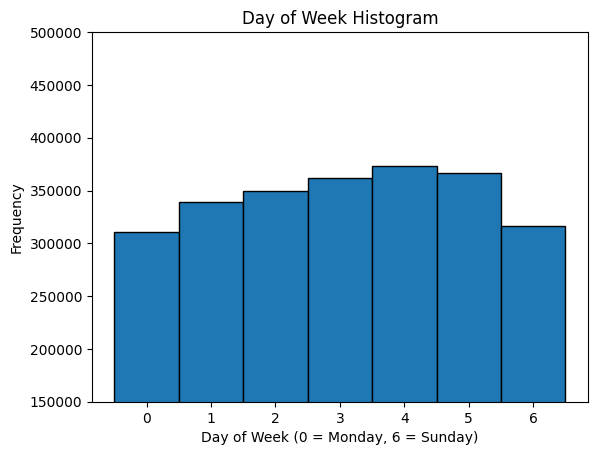

In [9]:
df['day_of_week'].plot.hist(bins = np.arange(8) - 0.5 , ec = 'black', ylim = (150000 , 500000))
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.title('Day of Week Histogram')

Text(0.5, 0, 'Hour')

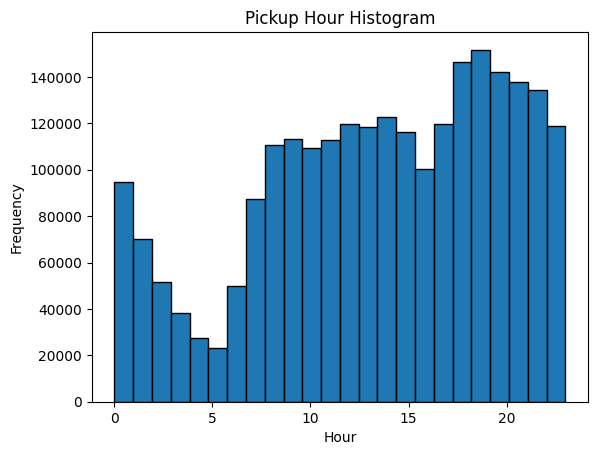

In [10]:
df['hour'].plot.hist(bins = 24, ec = 'black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')

Text(0.5, 1.0, 'Histogram of Fares')

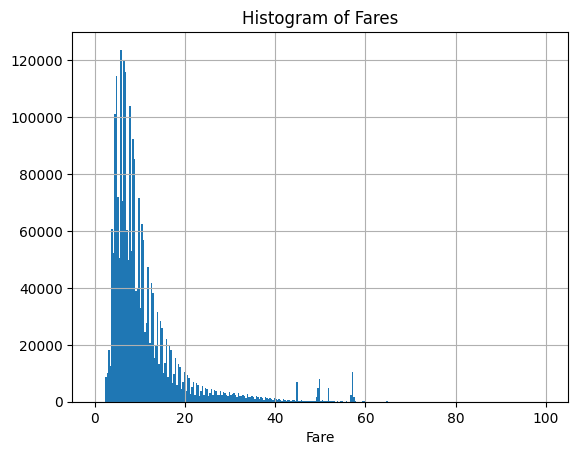

In [11]:
df['fare_amount'].hist(bins = 300)
plt.xlabel("Fare")
plt.title("Histogram of Fares")

Text(0.5, 1.0, 'Histogram of Passenger Count')

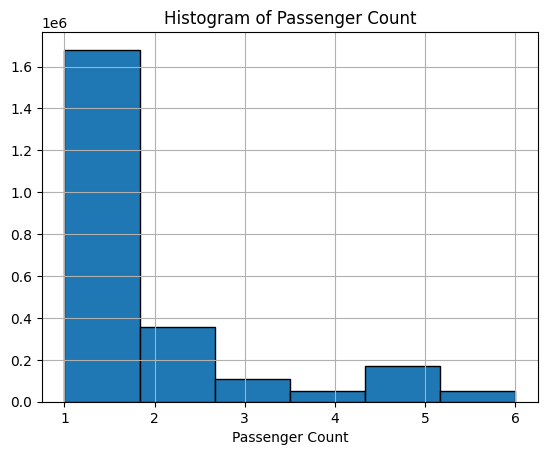

In [12]:
df['passenger_count'].hist(bins = 6 , ec = 'black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

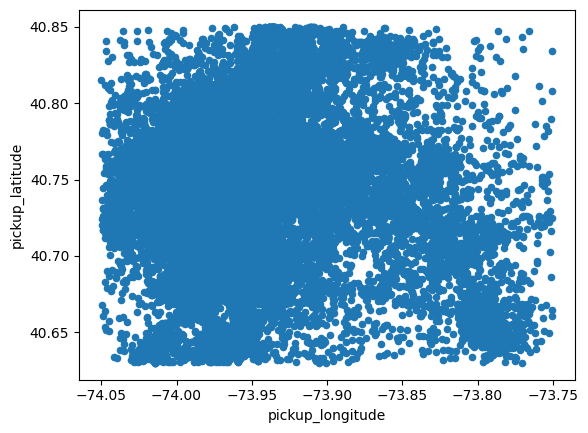

In [13]:
df.plot.scatter('pickup_longitude', 'pickup_latitude')  

In [14]:
df2 = df.head(500000) # loading in less training examples for clarity sake

<AxesSubplot:xlabel='travel_distance', ylabel='fare_amount'>

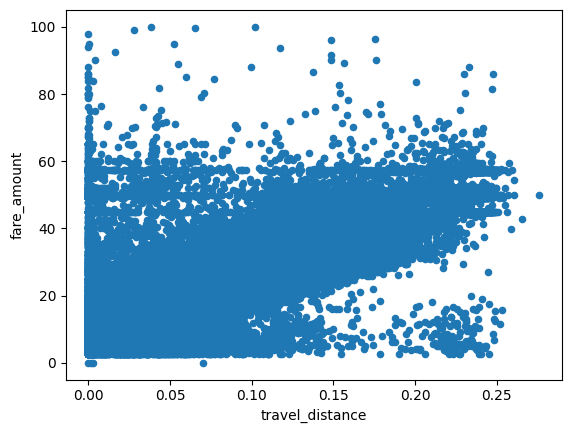

In [15]:
df2.plot.scatter('travel_distance' , 'fare_amount')

### Feature scaling

In [16]:
X = df.drop(['fare_amount'] , axis = 1)
y = df.fare_amount

In [17]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2)

In [18]:
X_train , X_val , y_train , y_val = train_test_split(X_train , y_train , test_size = 0.2)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [20]:
X_train = scaler.transform(X_train)
X_train

array([[-0.01452063,  0.96992845,  0.03942185, ..., -0.33268157,
         0.19459345,  0.10644334],
       [-0.98247962, -1.17876923, -0.64912728, ...,  0.60729814,
        -1.15732154, -0.643942  ],
       [ 0.03989604,  0.09847828, -0.39162059, ...,  0.58200624,
         0.01907389, -0.59730663],
       ...,
       [-0.22581877,  0.77537905,  0.20651521, ..., -0.38524904,
        -0.04795242,  0.6634355 ],
       [ 0.00551188,  1.47496391,  3.37714096, ..., -2.52573416,
         0.3688907 ,  3.61925263],
       [ 0.43196518,  0.79897812, -0.46349242, ...,  0.38364511,
         0.54346312, -0.49045428]])

### Model building

##### XGBRegressor

In [21]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

##### Deep feedforward network

In [52]:
model = Sequential([ 
    tf.keras.Input(shape = X_train.shape[1]) ,
    Dense(units = 128 , activation = 'relu') , 
    Dense(units = 64 , activation = 'relu') , 
    Dense(units = 32 , activation = 'relu') , 
    Dense(units = 8 , activation = 'relu') , 
    Dense(units = 1)
])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,529
Trainable params: 12,529
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(loss = 'mse' , optimizer = Adam() , metrics = ['mse'])
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
60439/60439 [==============================] - 177s 3ms/step - loss: 13.7814 - mse: 13.7814
Epoch 2/10
60439/60439 [==============================] - 179s 3ms/step - loss: 12.8273 - mse: 12.8273
Epoch 3/10
60439/60439 [==============================] - 167s 3ms/step - loss: 12.6161 - mse: 12.6161
Epoch 4/10
60439/60439 [==============================] - 178s 3ms/step - loss: 12.4851 - mse: 12.4851
Epoch 5/10
60439/60439 [==============================] - 161s 3ms/step - loss: 12.4073 - mse: 12.4073
Epoch 6/10
60439/60439 [==============================] - 165s 3ms/step - loss: 12.3504 - mse: 12.3504
Epoch 7/10
60439/60439 [==============================] - 168s 3ms/step - loss: 12.2968 - mse: 12.2968
Epoch 8/10
60439/60439 [==============================] - 136s 2ms/step - loss: 12.2610 - mse: 12.2610
Epoch 9/10
60439/60439 [==============================] - 92s 2ms/step - loss: 12.2188 - mse: 12.2188
Epoch 10/10
60439/60439 [==============================] - 96s 2ms/step - 

### Results analysis

In [22]:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

##### XGBoost

In [23]:
train_pred = xgbr.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train , train_pred))

val_pred = xgbr.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val , val_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Validation set RMSE: {:0.2f}".format(val_rmse))

Train RMSE: 3.31
Validation set RMSE: 3.47


###### Generalization error

In [24]:
test_pred = xgbr.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test , test_pred))

print("Generalization error: {:0.2f}".format(test_rmse))

Generalization error: 3.43


##### Deep feedforward network

In [55]:
train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train , train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test , test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

15110/15110 [==============================] - 19s 1ms/step
Train RMSE: 3.50
Test RMSE: 3.58


### Saving(pickling) the model

In [25]:
data = {'model' : xgbr , 'scaler' : scaler}
with open('saved_model.pkl' , 'wb') as file:
    pickle.dump(data , file)